# Adding custom feature to TE
 
TE comes with several built-in features, such as `LogFp8TensorStats`, which can log statistics for each tensor involved in matrix multiplication (GEMM) operations.
In this tutorial, we'll demonstrate how to extend TE by adding a custom feature that logs the percentage of elements in a tensor whose absolute values exceed a configurable threshold `t`, as specified in the config file.


We create a file `/home/pgadzinski/TE/docs/debug/custom_feature_dir/percentage_greater_than_threshold.py` with the following content:

```python
    from typing import Dict, Optional

import torch

from nvdlfw_inspect.registry import Registry, api_method
from nvdlfw_inspect.logging import MetricLogger

from transformer_engine.debug.features.api import TEConfigAPIMapper
from transformer_engine.pytorch.tensor import QuantizedTensor, Quantizer


# Class should inherit from TEConfigAPIMapper and be registered to the transformer_engine namespace.
@Registry.register_feature(namespace="transformer_engine")
class PercentageGreaterThanThreshold(TEConfigAPIMapper):

    @api_method
    def inspect_tensor(
        self,
        config: Dict,
        layer_name: str,
        tensor_name: str,
        iteration: int,
        tp_group: torch.distributed.ProcessGroup,
        tensor: torch.Tensor,
        rowwise_quantized_tensor: Optional[torch.Tensor | QuantizedTensor] = None,
        columnwise_quantized_tensor: Optional[torch.Tensor | QuantizedTensor] = None,
        quantizer: Optional[Quantizer] = None,
    ):
        # API call inspect_tensor is used to gather the data about the tensor.
        # All API calls are documented in the `Precision debug tools / API / Calls to Nvidia-DL-Framework-Inspect`
        # section of the documentation.

        threshold = config["threshold"]
        percentage = (tensor > threshold).sum() / tensor.numel()

        # MetricLogger is a class from nvidia-dlframework-inspect.
        # By using it we can also use functionalities provided by nvidia-dlframework-inspect,
        # like logging to TensorBoard, etc.
        MetricLogger.log_scalar(
            f"{layer_name}_{tensor_name}_percentage_greater_than_threshold", percentage, iteration
        )

    @api_method
    def inspect_tensor_enabled(
        self, config: Dict, layer_name: str, tensor_name: str, iteration: int
    ):
        # This call is used by TE to determine if the unfused debug layer - which is slower - needs to be run.
        # It returns a tuple (bool, int), where the int indicates the next iteration when the feature will be enabled
        # and bool indicates if the feature should be enabled at the current iteration.
        
        
        run_current = iteration % config["freq"] == 0
        # run in next multiple of freq
        next_iter = iteration + (config["freq"] - iteration % config["freq"])
        return run_current, next_iter
```

Let's add the stat to the config file
```yaml
stats:
  enabled: True
  layers:
    layer_name_regex_pattern: .*
  transformer_engine:
    PercentageGreaterThanThreshold:
      enabled: True
      tensors: [activation]
      threshold: 0.1
      freq: 5
    LogTensorStats:
      enabled: True
      tensors: [activation]
      stats: [min]
      freq: 5
```

To use this feature one needs to add `WORKDIR/log_stat_greater_than_t.py` to `debug_api.initialize(feature_dirs=...`.


In [1]:
import os, time
import torch
import transformer_engine.pytorch as te
import nvdlfw_inspect.api as debug_api

te_dir = "/home/pgadzinski/TE" # setup TE dir as environment variable to run this script
log_dir = "./log"

debug_api.initialize(
    config_file=te_dir + "/docs/debug/custom_feature_dir/custom_feature_example_config.yaml",
    feature_dirs=[
        te_dir + "/transformer_engine/debug/features", 
        te_dir + "/docs/debug/custom_feature_dir"
    ],
    log_dir=log_dir,
    default_logging_enabled=True)


module = te.Linear(128, 128, name="linear_1")
inp = torch.randn(128, 128).cuda()
times = []
for _ in range(100):
    time_start = time.time()
    inp.normal_()
    out = module(inp)
    out.sum().backward()
    debug_api.step()
    torch.cuda.synchronize()
    time_end = time.time()
    times.append(time_end - time_start)

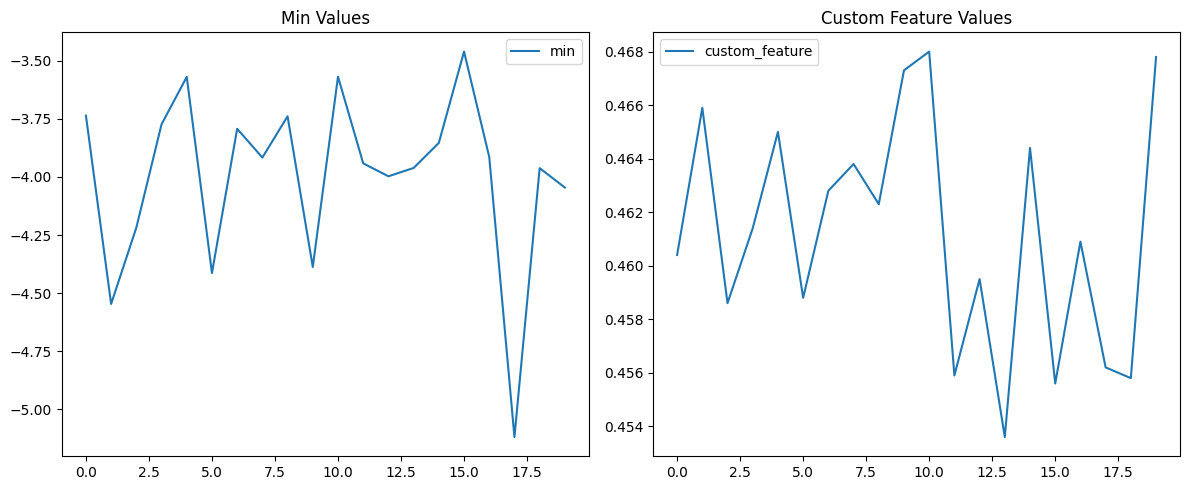

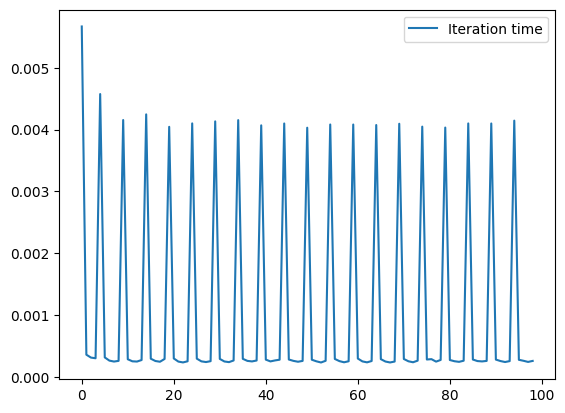

In [4]:
from custom_feature_dir.utils import plot_stats, plot_times_per_iteration

plot_stats(log_dir)
plot_times_per_iteration(times)
